In [1]:
from hmmlearn import hmm

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 20 days


In [2]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

In [3]:
import nilmtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
from nilmtk import *
import os
import nilmtk

In [6]:
ds = DataSet("/Users/nipunbatra/wikienergy-2013_ipsn.h5")

In [7]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")

In [8]:
b = ds.buildings[2]

In [9]:
b.metadata

{'dataset': 'Dataport', 'instance': 2, 'original_name': 370}

In [10]:
e = ds.buildings[2].elec

In [82]:
#models = {}

#for appliance in ["air conditioner", "fridge", "spin dryer", 
#                  "dish washer", "washing machine", "light"]:
for appliance in [ "dish washer"]:
    print appliance, "training"
    o = []
    for building_num in range(1, len(ds.buildings)):
        
        building = ds.buildings[building_num]
        elec = building.elec
        try:
            dft = elec.select_using_appliances(type=appliance).load(cols=[('power','active')], sample_period=900).next().squeeze()
            appl_power = dft.dropna().values.reshape(-1,1)
            activation = (dft>10).sum()*1.0/len(df)
            if appliance in ["washer dryer", "dishwasher"]:
                o.append(appl_power)
                
            else:
                if activation>0.05:
                    o.append(appl_power)
        except:
            pass
    
    if len(o)>1:
        o = np.array(o)
        mod = hmm.GaussianHMM(2, "full")
        mod.fit(o)
        models[appliance] = mod
        print "Means for %s are" %appliance
        print mod.means_
    else:
        print "Not enough samples for %s" %appliance

dish washer training
Loading data for meter ElecMeterID(instance=1, building=1, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=3, building=2, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=3, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=3, building=4, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=5, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=6, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=7, dataset='Dataport')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=1, building=8, dataset='Dataport

In [83]:
from nilmtk.disaggregate.fhmm_exact import sort_learnt_parameters

In [84]:
new_learnt_models = OrderedDict()
for appliance, appliance_model in models.iteritems():
    startprob, means, covars, transmat = sort_learnt_parameters(
                    appliance_model.startprob_, appliance_model.means_,
                    appliance_model.covars_, appliance_model.transmat_)
    new_learnt_models[appliance] = hmm.GaussianHMM(
                startprob.size, "full", startprob, transmat)
    new_learnt_models[appliance].means_ = means
    new_learnt_models[appliance].covars_ = covars

In [85]:
from nilmtk.disaggregate.fhmm_exact import create_combined_hmm

In [86]:
learnt_model_combined = create_combined_hmm(new_learnt_models)

In [87]:
from nilmtk.disaggregate.fhmm_exact import FHMM

In [88]:
f = FHMM()

In [89]:
f.model = learnt_model_combined
f.individual = new_learnt_models

In [90]:
import pickle

In [91]:
pickle.dump(f, open( "../fhmm_model_all.p", "wb" ))

In [8]:
all_homes_all_appliance = []
for appliance in ["fridge","hvac","dr","dw","wm","light"]:
    all_homes_all_appliance = np.union1d(all_homes_all_appliance, all_homes[appliance])

In [14]:
len(all_homes_all_appliance)

43

In [136]:
st_out = pd.HDFStore("../fhmm_out.h5")
for home in all_homes_all_appliance[:]:
    print home
    try:
        mains_df = st['/%d' %home][['use']]['2013'].resample("15T")
        pred = f.disaggregate_chunk(mains_df).resample("1M", how="sum").mul(0.000017).mul(15)
        pred.index = range(1, 13)
        pred = pred.rename(columns={'air conditioner':'hvac','dish washer':'dw',
                                    'spin dryer':'dr','washing machine':'wm'})
        st_out['%d' %home] = pred
    except:
        pass
    


26.0
94.0
370.0
410.0
545.0
624.0
1283.0
1334.0
1642.0
1953.0
2129.0
2156.0
2242.0
2470.0
2814.0
3367.0
3456.0
3482.0
3723.0
3967.0
4732.0
4767.0
5357.0
5371.0
5746.0
5785.0
5814.0
6072.0
6636.0
6836.0
6910.0
7016.0
7731.0
7769.0
7866.0
8317.0
9052.0
9609.0
9654.0
9922.0
9933.0
9934.0
9982.0


In [171]:
fhmm_accur = {}
for appliance in ["hvac","fridge","dw","wm","light","dr"]:
    print appliance
    
    if appliance =="hvac":
        start, end = 5, 11
    else:
        start, end = 1, 13
    out_ap = {}
    accuracies = {}
    for home in all_homes[appliance][:]:
        out_ap[home] = {}
        pred = st_out['/%d' %home][appliance]
        for month in range(start, end):
            out_ap[home][month] = {}
            gt = df.ix[home]['%s_%d' %(appliance, month)]
            out_ap[home][month]['gt'] = gt
            out_ap[home][month]['pred'] = pred.ix[month]
        a = pd.DataFrame(out_ap[home]).T
        e = (a['gt']-a['pred']).abs().div(a['gt'])*100
        accur = 100-e
        accur[accur<0] = 0
        accuracies[home] = accur
    fhmm_accur[appliance] = pd.DataFrame(accuracies).T.mean().mean()

hvac
fridge
dw
wm
light
dr


In [173]:
pd.Series(fhmm_accur)
        

dr        25.153495
dw         0.910221
fridge    36.026096
hvac      63.142434
light     42.775984
wm         1.988979
dtype: float64

In [170]:
pd.Series(fhmm_accur)


dr        11.410384
dw         0.000000
fridge    28.341138
hvac      64.629633
light     44.348418
wm         0.000000
dtype: float64

In [18]:
st_out = pd.HDFStore("../fhmm_lbm.h5")

for home in all_homes_all_appliance[:]:
    print home
    try:
        pred = pd.read_csv("/Users/nipunbatra/Dropbox/Public/notebooks/misc/%d.csv" %home, index_col=0)
        pred.index = pd.to_datetime(pred.index)
        pred = pred['2013']
        pred = pred.resample("1M", how="sum").mul(0.000017).mul(15)
        pred.index = range(1, 13)
        pred = pred[['hvac','dw','dr','fridge','wm','light']]
        
        st_out['%d' %home] = pred
    except Exception, e:
        print e
    
    

26.0
94.0
370.0
410.0
545.0
624.0
1283.0
1334.0
1642.0
1953.0
2129.0
2156.0
2242.0
2470.0
2814.0
3367.0
3456.0
3482.0
3723.0
3967.0
4732.0
4767.0
5357.0
5371.0
5746.0
5785.0
5814.0
6072.0
6636.0
6836.0
6910.0
7016.0
7731.0
7769.0
7866.0
8317.0
9052.0
9609.0
9654.0
9922.0
9933.0
9934.0
9982.0


In [23]:
lbm_accur = {}
for appliance in ["hvac","fridge","dw","wm","light","dr"]:
    print appliance
    
    if appliance =="hvac":
        start, end = 5, 11
    else:
        start, end = 1, 13
    out_ap = {}
    accuracies = {}
    for home in all_homes[appliance][:]:
        out_ap[home] = {}
        pred = st_out['/%d' %home][appliance]
        for month in range(start, end):
            out_ap[home][month] = {}
            gt = df.ix[home]['%s_%d' %(appliance, month)]
            out_ap[home][month]['gt'] = gt
            out_ap[home][month]['pred'] = pred.ix[month]
        a = pd.DataFrame(out_ap[home]).T
        e = (a['gt']-a['pred']).abs().div(a['gt'])*100
        accur = 100-e
        accur[accur<0] = 0
        accuracies[home] = accur
    lbm_accur[appliance] = pd.DataFrame(accuracies)

hvac
fridge
dw
wm
light
dr


In [31]:
%matplotlib inline

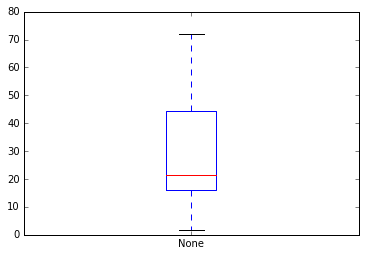

In [34]:
lbm_accur['wm'].mean().plot(kind="box")

In [67]:
lbm = LatentBayesianMelding()

In [68]:
meterlist = ['hvac','fridge','dr','dw','wm','light']
individual_model = lbm.import_model(meterlist,'/Users/nipunbatra/Desktop/lbn.json')


The trained meter: hvac
The trained meter: fridge
The trained meter: dr
The trained meter: dw
The trained meter: wm
The trained meter: light


In [71]:
st_out = pd.HDFStore("../lbn_out.h5")
#for home in all_homes_all_appliance[:1]:
for home in [3723]:
    print home
    try:
        mains_df = st['/%d' %home]['use']['2013'].resample("15T").astype('float64').dropna()
        pred = lbm.disaggregate_chunk(mains_df)['inferred appliance energy']
        pred = pred.resample("1M", how="sum").mul(0.000017).mul(15)
        pred.index = range(1, 13)
        
        st_out['%d' %home] = pred
    except Exception, e:
        print e

3723
----------------------------------------------------------------------------------------------------
*************Iteration: 1*****************
Employing the Mosek solver to solve the problem:

Declaring variables and constraints...


 Solving the problem ...

+++++++++++++++optimization status+++++++++++++++++++
Number of variables:2802592
Number of constraints:1786656
Primal solution status:SolutionStatus.Optimal
Primal value:6537610.57551
Dual solution status:SolutionStatus.Optimal
Dual value:6537610.6094
Accepted solution status:AccSolutionStatus.Anything
+++++++++++++++optimization status+++++++++++++++++++
Solving this problem took '569.297924042' seconds

 log(datalikelihood*prior)=-265855.344863

*************Iteration: 2*****************
Employing the Mosek solver to solve the problem:

Declaring variables and constraints...


 Solving the problem ...

+++++++++++++++optimization status+++++++++++++++++++
Number of variables:2802592
Number of constraints:1786656
Primal so

In [31]:
st_out = pd.HDFStore("../lbn_out.h5")
for home in all_homes_all_appliance[:1]:
    print home
    try:
        mains_df = st['/%d' %home]['use']['2013'].resample("15T").astype('float64').dropna()
        pred = lbm.disaggregate_chunk(mains_df)['inferred appliance energy']
        #pred = pred.resample("1M", how="sum").mul(0.000017).mul(15)
        #pred.index = range(1, 13)
        
        st_out['%d' %home] = pred
    except Exception, e:
        print e

26.0
----------------------------------------------------------------------------------------------------
*************Iteration: 1*****************
Employing the Mosek solver to solve the problem:

Declaring variables and constraints...


 Solving the problem ...

+++++++++++++++optimization status+++++++++++++++++++
Number of variables:2798757
Number of constraints:1784208
Primal solution status:SolutionStatus.Optimal
Primal value:1.3630996243e+11
Dual solution status:SolutionStatus.Optimal
Dual value:1.36309962432e+11
Accepted solution status:AccSolutionStatus.Anything
+++++++++++++++optimization status+++++++++++++++++++
Solving this problem took '574.833842993' seconds

 log(datalikelihood*prior)=-64359053.573

*************Iteration: 2*****************
Employing the Mosek solver to solve the problem:

Declaring variables and constraints...


 Solving the problem ...

+++++++++++++++optimization status+++++++++++++++++++
Number of variables:2798757
Number of constraints:1784208
Pr

In [27]:
mains_df = st['/%d' %home]['use']['2013'].resample("15T").astype('float64').dropna()

In [30]:
mains_df.isnull().sum()

56

In [24]:
%matplotlib inline

In [69]:
all_homes

{'dr': Int64Index([  94,  370,  410,  624, 1283, 2156, 2242, 2814, 3367, 3456, 3482,
             3723, 3967, 4732, 4767, 5746, 5785, 5814, 6072, 6636, 6836, 7016,
             7731, 7769, 7866, 8317, 9052, 9654, 9922, 9933, 9934, 9982],
            dtype='int64'),
 'dw': array([  26,   94,  370,  545,  624, 1334, 1642, 2156, 2242, 2814, 3367,
        3456, 3482, 3723, 3967, 4767, 5357, 5746, 6072, 6636, 6836, 6910,
        7769, 9922, 9934, 9982]),
 'fridge': array([  94,  370,  410,  545,  624, 1953, 2156, 2242, 2814, 3367, 3456,
        3723, 3967, 4767, 5357, 5371, 6072, 6636, 6910, 7769, 7866]),
 'hvac': array([  26,  370,  410,  545,  624, 1283, 1642, 1953, 2129, 2156, 2242,
        2814, 3367, 3456, 3723, 3967, 4767, 5357, 5371, 5746, 5785, 5814,
        6072, 6636, 6836, 6910, 7731, 7769, 7866, 9654, 9922, 9933, 9934]),
 'light': [624,
  1334,
  2470,
  3367,
  3456,
  3723,
  5814,
  6072,
  6910,
  7769,
  7866,
  9609,
  9654,
  9922],
 'wm': array([  94,  370,  545,  624, 2

In [72]:
pred

,hvac,fridge,dr,dw,wm,light,inferred mains,mains
1,2.075334,0.081192,0.631526,0.000234,0.000010,0.035137,2.823433,541.252681
2,1.521923,0.078441,0.530816,0.000199,0.000009,0.045339,2.176725,484.536295
3,2.077225,0.088123,0.628409,0.000232,0.000010,0.052969,2.846967,515.117968
4,2.028914,0.081727,0.600235,0.000222,0.000009,0.045559,2.756666,482.072451
5,1.273544,0.087758,0.499462,0.000183,0.000009,0.029258,1.890215,725.896277
6,0.866553,0.149311,0.434272,0.000158,0.000009,0.044714,1.495016,1358.322966
7,1.147455,0.169087,0.479262,0.000174,0.000009,0.061758,1.857746,1033.511226
8,0.821832,0.175474,0.414704,0.000151,0.000009,0.070377,1.482547,1508.695582
9,0.784201,0.172887,0.398410,0.000145,0.000008,0.073070,1.428720,1365.374109
10,1.740631,0.180482,0.537853,0.000194,0.000009,0.079099,2.538269,1028.600811


In [33]:
pred = pred.resample("1M", how="sum").mul(0.000017).mul(15)
pred.index = range(1, 13)

In [34]:
pred

,hvac,fridge,dr,dw,wm,light,inferred mains,mains
1,0.646548,108.136715,0.553805,0.069589,0.023172,0.038275,109.468105,534.915914
2,0.595282,111.916720,0.547823,0.063200,0.020964,0.034633,113.178623,408.059619
3,0.646566,107.493156,0.550758,0.069694,0.023194,0.038323,108.821691,401.911399
4,0.617789,100.082804,0.530757,0.067015,0.022375,0.036865,101.357605,501.315431
5,0.639847,107.788677,0.522146,0.069608,0.023217,0.038398,109.081892,972.204364
6,0.628541,129.137553,0.518679,0.067912,0.022595,0.037552,130.412833,1459.766217
7,0.655617,141.617232,0.558128,0.070498,0.023405,0.038977,142.963857,1376.049360
8,0.642024,142.451768,0.505541,0.070405,0.023463,0.039150,143.732351,1734.195534
9,0.624123,133.038099,0.521399,0.067879,0.022592,0.037554,134.311646,1435.453361
10,0.630863,134.300396,0.499349,0.069575,0.023248,0.038524,135.561955,1043.317743


In [57]:
appliance="dw"
month=3
home=26
gt = df.ix[home]['%s_%d' %(appliance, month)]

In [58]:
gt

0.0

In [50]:
all_homes['dw']

array([  26,   94,  370,  545,  624, 1334, 1642, 2156, 2242, 2814, 3367,
       3456, 3482, 3723, 3967, 4767, 5357, 5746, 6072, 6636, 6836, 6910,
       7769, 9922, 9934, 9982])

In [65]:
df.ix[94]['dw_5']

4.389723300930001